In [1]:
from local_vars import root_folder

data_folder = r"CentralLinePhantom1"
image_size = 128

In [2]:
import pandas as pd
import itertools
import os
import keras

from keras.models import Sequential
from keras.layers import Activation, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.utils import Sequence

from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from skimage.io import imread
from skimage.transform import resize

Using TensorFlow backend.


In [3]:
data_fullpath = os.path.join(root_folder, data_folder)
train_fullpath = os.path.join(data_fullpath, "train")
valid_fullpath = os.path.join(data_fullpath, "valid")
test_fullpath = os.path.join(data_fullpath, "test")

print("Training data folder:   {}".format(train_fullpath))
print("Validation data folder: {}".format(valid_fullpath))
print("Test data folder:       {}".format(test_fullpath))

Training data folder:   j:\Temp\CentralLinePhantom1\train
Validation data folder: j:\Temp\CentralLinePhantom1\valid
Test data folder:       j:\Temp\CentralLinePhantom1\test


In [4]:
import numpy as np

train_images_fullpath = os.path.join(train_fullpath, "images.npy")
train_classes_fullpath = os.path.join(train_fullpath, "classes.npy")
train_locations_fullpath = os.path.join(train_fullpath, "locations.npy")
train_image_data = np.load(train_images_fullpath)
train_class_data = np.load(train_classes_fullpath)
train_locations_data = np.load(train_locations_fullpath)

num_train_images = train_image_data.shape[0]
train_image_min_value = np.amin(train_image_data)
train_image_max_value = np.amax(train_image_data)

valid_images_fullpath = os.path.join(valid_fullpath, "images.npy")
valid_classes_fullpath = os.path.join(valid_fullpath, "classes.npy")
valid_locations_fullpath = os.path.join(valid_fullpath, "locations.npy")
valid_image_data = np.load(valid_images_fullpath)
valid_class_data = np.load(valid_classes_fullpath)
valid_locations_data = np.load(valid_locations_fullpath)

num_valid_images = valid_image_data.shape[0]
valid_image_min_value = np.amin(valid_image_data)
valid_image_max_value = np.amax(valid_image_data)

test_images_fullpath = os.path.join(test_fullpath, "images.npy")
test_classes_fullpath = os.path.join(test_fullpath, "classes.npy")
test_locations_fullpath = os.path.join(test_fullpath, "locations.npy")
test_image_data = np.load(test_images_fullpath)
test_class_data = np.load(test_classes_fullpath)
test_locations_data = np.load(test_locations_fullpath)

num_test_images = test_image_data.shape[0]
test_image_min_value = np.amin(test_image_data)
test_image_max_value = np.amax(test_image_data)

if train_image_data.shape[1] != image_size:
    raise ValueError("Input image size does not match input size of TF model!")

In [5]:
print("Training data\n")
print("Num of training images:  {}".format(num_train_images))
print("Pixel intensity range:   {} to {}".format(train_image_min_value, train_image_max_value))
print("Image size:              {} x {}".format(train_image_data.shape[1], train_image_data.shape[2]))
print("Class data shape:        {}".format(train_class_data.shape))
print("Class min max:           {}, {}".format(np.amin(train_class_data), np.amax(train_class_data)))
print("Locations data shape:    {}".format(train_locations_data.shape))
print("Location mins:           {}".format(np.amin(train_locations_data, axis=0)))
print("Location maxs:           {}".format(np.amax(train_locations_data, axis=0)))
print("")
print("Validation data\n")
print("Found validation images: {}".format(num_valid_images))
print("Pixel intensity range:   {} to {}".format(valid_image_min_value, valid_image_max_value))
print("Image size:              {} x {}".format(valid_image_data.shape[1], valid_image_data.shape[2]))
print("Class data shape:        {}".format(valid_class_data.shape))
print("Class min max:           {}, {}".format(np.amin(valid_class_data), np.amax(valid_class_data)))
print("Locations data shape:    {}".format(valid_locations_data.shape))
print("Location mins:           {}".format(np.amin(valid_locations_data, axis=0)))
print("Location maxs:           {}".format(np.amax(valid_locations_data, axis=0)))
print("")
print("Test data\n")
print("Found test images:       {}".format(num_test_images))
print("Pixel intensity range:   {} to {}".format(test_image_min_value, test_image_max_value))
print("Image size:              {} x {}".format(test_image_data.shape[1], test_image_data.shape[2]))
print("Locations data shape:    {}".format(test_locations_data.shape))
print("Location mins:           {}".format(np.amin(test_locations_data, axis=0)))
print("Location maxs:           {}".format(np.amax(test_locations_data, axis=0)))


Training data

Num of training images:  1086
Pixel intensity range:   0.0 to 1.0
Image size:              128 x 128
Class data shape:        (1086, 1)
Class min max:           1.0, 1.0
Locations data shape:    (1086, 2)
Location mins:           [0.08986112 0.20468754]
Location maxs:           [0.66065168 0.78363067]

Validation data

Found validation images: 225
Pixel intensity range:   0.0 to 1.0
Image size:              128 x 128
Class data shape:        (225, 1)
Class min max:           1.0, 1.0
Locations data shape:    (225, 2)
Location mins:           [0.34189731 0.56308657]
Location maxs:           [0.45830593 0.72174707]

Test data

Found test images:       191
Pixel intensity range:   0.0 to 1.0
Image size:              128 x 128
Locations data shape:    (191, 2)
Location mins:           [0.32834005 0.558669  ]
Location maxs:           [0.45733333 0.73468047]


Example input image with true location


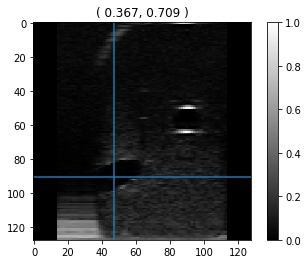

In [6]:
print("Example input image with true location")
plt.title("( {:.3f}, {:.3f} )".format(valid_locations_data[0][0], valid_locations_data[0][1]))
plt.imshow(valid_image_data[0][:,:,0], cmap='gray')
plt.axvline(x=valid_locations_data[0][0] * image_size)
plt.axhline(y=valid_locations_data[0][1] * image_size)
out = plt.colorbar()

In [7]:
def plots(ims, ys, figsize=(20,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i][:, :, 0], cmap='gray')
        plt.axvline(x=ys[i][0] * image_size)
        plt.axhline(y=ys[i][1] * image_size)

Example test locations:
[[0.45538291 0.56274751]
 [0.4387303  0.58397627]
 [0.38943648 0.61430007]
 [0.35738999 0.68952891]
 [0.34727001 0.73059699]
 [0.33946007 0.72641432]]
Example validation locations:
[[0.36699113 0.70884946]
 [0.3697325  0.67535776]
 [0.39504194 0.60471946]
 [0.39739978 0.58453369]
 [0.41939196 0.56938791]
 [0.45640165 0.56389496]]


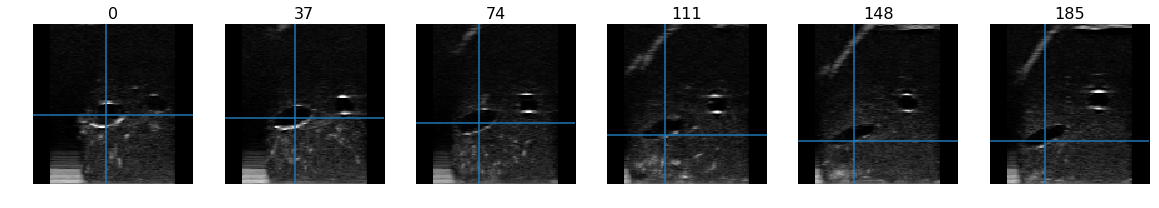

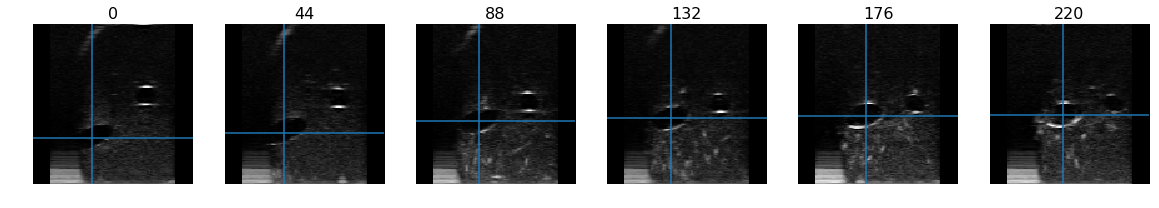

In [8]:
test_inspect_indices = np.arange(0, num_test_images, int(num_test_images/5)-1)
test_inspect_images = test_image_data[(test_inspect_indices)]
test_inspect_locations = test_locations_data[(test_inspect_indices)]

valid_inspect_indices = np.arange(0, num_valid_images, int(num_valid_images/5)-1)
valid_inspect_images = valid_image_data[(valid_inspect_indices)]
valid_inspect_locations = valid_locations_data[(valid_inspect_indices)]

print("Example test locations:\n{}".format(test_inspect_locations))
plots(test_inspect_images, test_inspect_locations, titles=test_inspect_indices)

print("Example validation locations:\n{}".format(valid_inspect_locations))
plots(valid_inspect_images, valid_inspect_locations, titles=valid_inspect_indices)

In [9]:
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(image_size, image_size, 1)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(.2))
model.add(Dense(2, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
__________

In [10]:
model.compile(SGD(lr=.1), loss='mse', metrics=['mean_squared_error'])

In [17]:
num_epochs = 8
batch_size = 100

history = model.fit(
    train_image_data,
    train_locations_data,
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=1,
    validation_data=(valid_image_data, valid_locations_data))

Train on 1086 samples, validate on 225 samples
Epoch 1/8
1086/1086 [==============================] - 2s 1ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2/8
1086/1086 [==============================] - 2s 1ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 3/8
1086/1086 [==============================] - 2s 1ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 4/8
1086/1086 [==============================] - 2s 1ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 5/8
1086/1086 [==============================] - 2s 1ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 6/8
1086/1086 [==============================] - 2s 1ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0032 - val_me

Text(0.5,1,'Accuracy Curves')

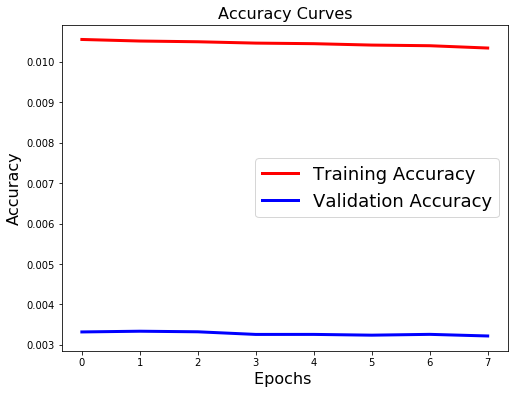

In [18]:
plt.figure(figsize=[8,6])
plt.plot(history.history['mean_squared_error'],'r',linewidth=3.0)
plt.plot(history.history['val_mean_squared_error'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Average error: 0.1011
Predicted test locations:
[[0.45093453 0.590939  ]
 [0.45212892 0.59222454]
 [0.45092383 0.5930949 ]
 [0.4507022  0.59289   ]
 [0.4506054  0.5923945 ]
 [0.45045754 0.5937378 ]]

True locations:
[[0.45538291 0.56274751]
 [0.4387303  0.58397627]
 [0.38943648 0.61430007]
 [0.35738999 0.68952891]
 [0.34727001 0.73059699]
 [0.33946007 0.72641432]]


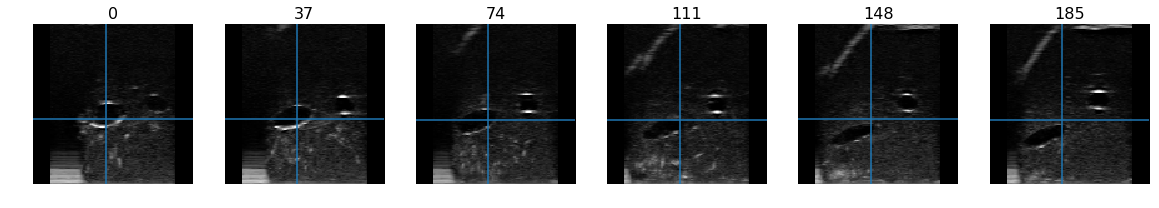

In [19]:
y_pred = model.predict(test_image_data)

n = len(test_locations_data)
average_error = 0.0
averaging_factor = 1.0 / n
for i in range(len(test_locations_data)):
    distance = np.linalg.norm(test_locations_data[i] - y_pred[i])
    average_error += distance * averaging_factor

print("Average error: {0:.4f}".format(average_error))    


pred_inspect_images = test_image_data[(test_inspect_indices)]
pred_inspect_locations = y_pred[(test_inspect_indices)]

print("Predicted test locations:\n{}\n".format(pred_inspect_locations))
print("True locations:\n{}".format(test_locations_data[(test_inspect_indices)]))
plots(pred_inspect_images, pred_inspect_locations, titles=test_inspect_indices)


In [14]:

print("\nTrue locations")
print(test_locations_data[:5])

print("\nPredicted locations")
print(y_pred[:5])


True locations
[[0.45538291 0.56274751]
 [0.45698801 0.563867  ]
 [0.45698801 0.563867  ]
 [0.45648396 0.56298372]
 [0.45579037 0.56159705]]

Predicted locations
[[0.45137328 0.59222794]
 [0.4512199  0.5922399 ]
 [0.4512199  0.5922399 ]
 [0.45129073 0.59220546]
 [0.45150533 0.5922104 ]]


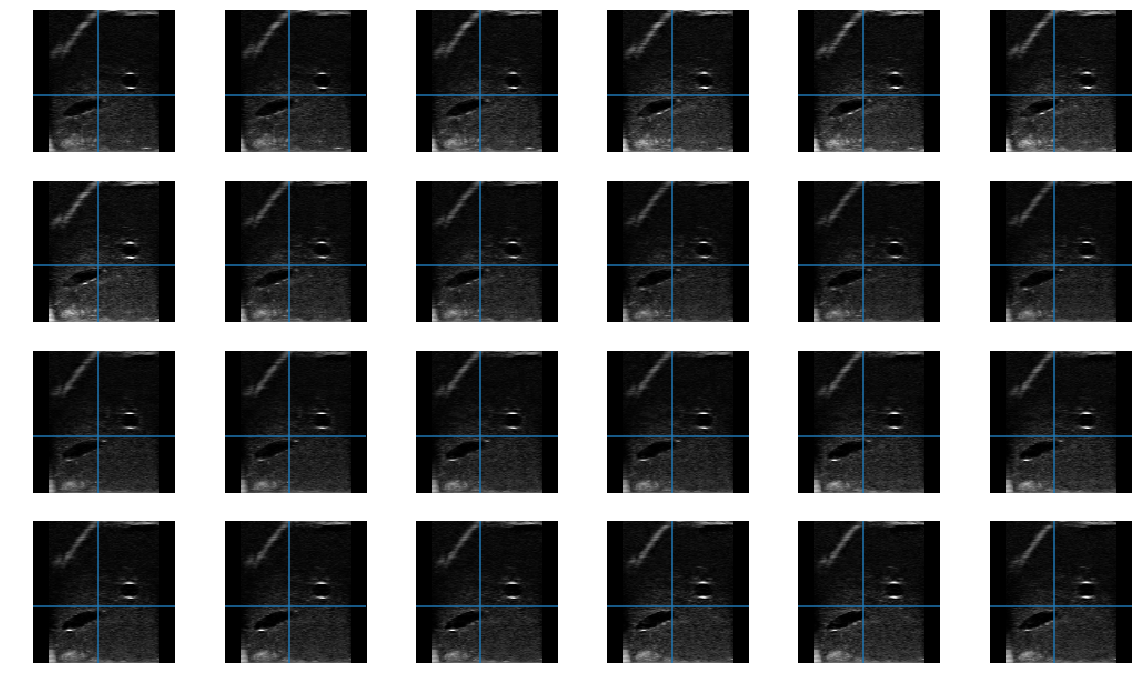

In [15]:
plots(test_image_data[140:164], y_pred[140:164], figsize=(20,12), rows=4)

In [16]:
import datetime

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

weights_folder = os.path.join(root_folder, "weights")

if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)
    print("Creating folder: {}".format(weights_folder))

weights_file_name = "weights_" + timestamp + ".h5"
weights_file_path = os.path.join(weights_folder, weights_file_name)

model.save_weights(weights_file_path)